In [1]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt

import random


In [2]:
def generate_real() -> torch.Tensor:
    """生成真实数据的生成器

    Returns:
        torch.Tensor: 生成接近1,0,1,0的随机数
    """
    real_data = torch.Tensor([
        random.uniform(0.8, 1.0),
        random.uniform(0.0, 0.2),
        random.uniform(0.8, 1.0),
        random.uniform(0.0, 0.2),
    ])
    return real_data

In [3]:
class Discriminator(nn.Module):
    # 分类器

    def __init__(self):
        
        # 初始化PyTorch父类
        super().__init__()
        
        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # 创建损失函数
        self.loss_function = nn.MSELoss()
        
        # 创建优化器, 使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(),lr=0.01)
        
        # 计数器和进程记录        
        self.counter = 0        
        self.progress = []


    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)
        
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        
        # 每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            
        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.3, 
            marker='.', grid=True, yticks=(0, 0.25, 0.5))


In [4]:
def generate_random(size) -> torch.Tensor:
    """生成随机数给上面分类器做测试

    Args:
        size (_type_): _description_

    Returns:
        torch.Tensor: _description_
    """
    random_data = torch.rand(size)
    return random_data

In [5]:
D = Discriminator()

for i in range(10000):
    # 真实数据
    D.train(generate_real(), torch.Tensor([1.0]))
    # 随机数
    D.train(generate_random(4), torch.Tensor([0.0]))


counter =  10000
counter =  20000


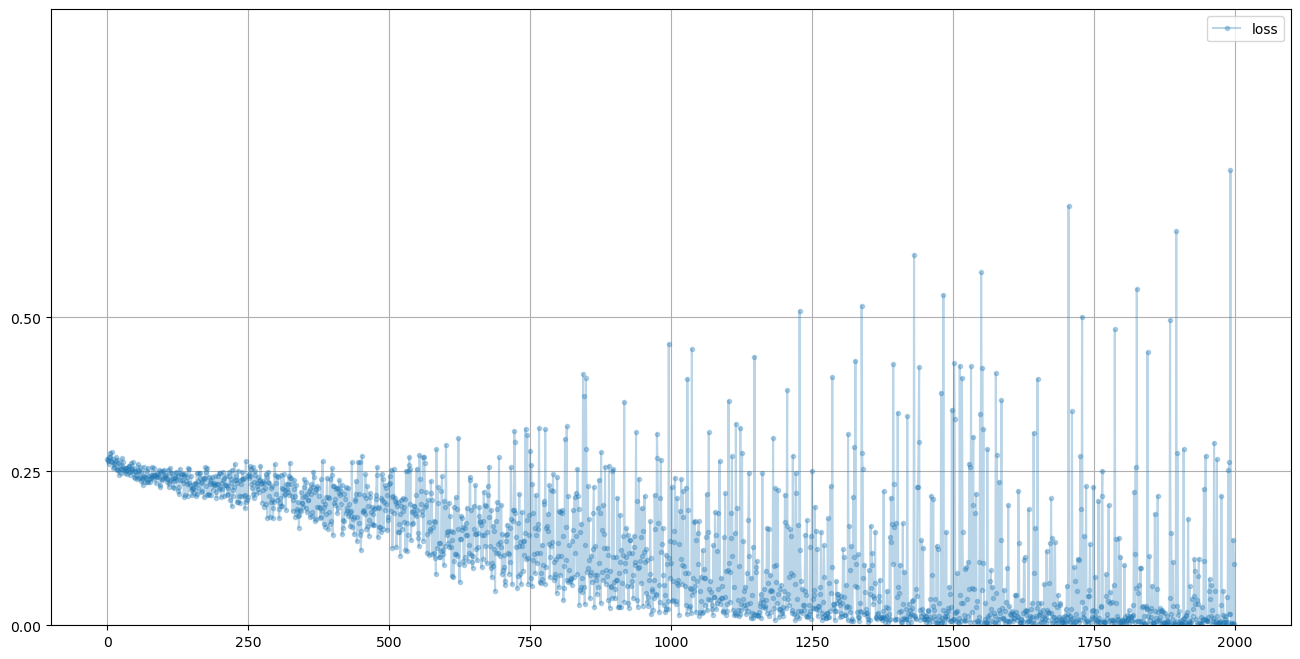

In [6]:
D.plot_progress()

用真实值带入，结果接近1

In [7]:
D.forward(generate_real())

tensor([0.8357], grad_fn=<SigmoidBackward0>)

用随机数带入，结果接近0

In [9]:
D.forward(generate_random(4))

tensor([0.1249], grad_fn=<SigmoidBackward0>)